In [13]:
# imports
import torch
import torchvision
import torchvision.transforms as transforms # common image transformations that can be chained together using Compose
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# set up MPS
device = 'cpu'

if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available.")

else:
    device = torch.device("mps")
    print("MPS is available!")

MPS is available!


The first step is to download our training and test datasets -- this is easy enough to do with `torchvision.datasets`. We apply a transform while downloading to convert the images into pytorch tensors and normalize their pixel values. From there, we create dataloaders

In [15]:
transform = transforms.Compose(
    [transforms.ToTensor(), # convert image to tensor
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # normalize pixel values of image

In [16]:
batch_size = 4 # number of images per batch

# download training dataset, apply transform, and load into DataLoader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, # load data in batches
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, # download test dataset
                                        download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, # load data in batches
                                          shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', # class labels
            'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [17]:
# utility function to show one image
def showimg(img):
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy array
  plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose to get correct image orientation
  plt.show()

In [18]:
# get some random training images
dataiter = iter(trainloader) # create an iterator
images, labels = next(dataiter) # get the next batch of images and labels

Next, we'll create a simple CNN to classify the images. This CNN consists of a few convolutional layers with maxpool layers between then, and then a few linear layers. The linear layers are the layers that will eventually be replaced with LoRA layers.

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # network layers defined below
        self.conv1 = nn.Conv2d(
            3, 6, 5
        ) # 3 input channels, 6 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2
        self.conv2 = nn.Conv2d(
            6, 16, 5
        ) # 6 input channels, 16 output channels, 5x5 kernel
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 kernel, stride of 2
        self.conv3 = nn.Conv2d(
            16, 32, 5
        ) # 16 input channels, 32 output channels, 5x5 kernel
        self.fc1 = nn.Linear(
            16 * 5 * 5, 120
        ) # 16 * 5 * 5 input features, 120 output features
        self.fc2 = nn.Linear(120, 84)  # 120 input features, 84 output features
        self.fc3 = nn.Linear(84, 10)  # 84 input features, 10 output features

    def forward(self, x):  # define the forward pass
        x = self.pool(F.relu(self.conv1(x)))  # convolve, apply ReLU, then pool
        x = self.pool(F.relu(self.conv2(x)))  # convolve, apply ReLU, then pool
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))  # apply ReLU
        x = F.relu(self.fc2(x))  # apply ReLU
        x = self.fc3(x)  # output layer
        return x

We'll also want a function to check out a model and print which parameters are or aren't trainable.

The assumption behind LoRA is that most large models are over-parameterized -- i.e., they have more weights than minimally required to represent the functions they're learning. LoRA carries this assumption even further and assumes that this concept also applies to model adaptations.

This means that, when finetuning a model, you only need to change a small subset (low-rank) of the weights. LoRA does this in an interesting and efficient way. Instead of directly choosing a subset of a model's weights to change, LoRA trains "auxiliary matrices" `A` and `B` instead. Think of the dot product of these matrices as "weight deltas" that can be added to the weights in the original layer to implement the adaptation.

For example, say you have a simple linear layer with `in_dim=100` and `out_dim=120`. `A` would be of shape `[in_dim, rank]` and `B` would be of shape `[rank, out_dim]`. The weights in the linear layer would be frozen and the auxiliary matrices would be trained instead. Afterward, at inference time, the output of the linear layer would be calculated as `output = linear(x) + B @ A`, effectively implementing the adaptations.

`rank` is a hyperparameter that can be changed to reduce the memory and compute required to train the auxiliary matrices.

In [20]:
def print_params(model: nn.Module):
  """
  Print the number of trainable and untrainable parameters in the model.
  
  Args:
    model: The model to print the parameters of.
  """
  trainable = 0 # number of trainable parameters
  untrainable = 0 # number of untrainable parameters
  trainable_size = 0 # size in mb of trainable parameters

  print("Layers:")
  for name, param in model.named_parameters():
    print(f"- {name} of size {param.size()} -> {'trainable' if param.requires_grad else 'untrainable'}")

    if param.requires_grad: # if the parameter requires a gradient
      trainable += param.numel() # increment the number of trainable parameters
      trainable_size += param.numel() * param.element_size() # increment the size of trainable parameters
    else: # otherwise
      untrainable += param.numel() # increment the number of untrainable parameters

  print(f"\nTrainable parameters: {trainable}")
  print(f"Untrainable parameters: {untrainable}")
  print(f"Total parameters: {trainable + untrainable}")
  print(f"Percent trainable: {100 * trainable / (trainable + untrainable)}%")
  percentage = trainable_size / 1e6
  print(f"Size of trainable parameters: {percentage:.2f} mb")

In [21]:
net = ConvNet() # create a ConvNet object
print_params(net) # print the number of trainable and untrainable parameters in the model

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> trainable
- conv1.bias of size torch.Size([6]) -> trainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> trainable
- conv2.bias of size torch.Size([16]) -> trainable
- conv3.weight of size torch.Size([32, 16, 5, 5]) -> trainable
- conv3.bias of size torch.Size([32]) -> trainable
- fc1.weight of size torch.Size([120, 400]) -> trainable
- fc1.bias of size torch.Size([120]) -> trainable
- fc2.weight of size torch.Size([84, 120]) -> trainable
- fc2.bias of size torch.Size([84]) -> trainable
- fc3.weight of size torch.Size([10, 84]) -> trainable
- fc3.bias of size torch.Size([10]) -> trainable

Trainable parameters: 74838
Untrainable parameters: 0
Total parameters: 74838
Percent trainable: 100.0%
Size of trainable parameters: 0.30 mb


In [22]:
import torch.optim as optim # package with common optimization algorithms

criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # optimizer

In [23]:
def train(model, criterion, optimizer, trainloader, num_epochs=2, device='cpu', announce=2000):
    model.to(device)  # move the model to the device

    for epoch in range(num_epochs):
        running_loss = 0.0  # keep track of running loss
        for i, data in enumerate(trainloader, 0):  # iterate over data
            inputs, labels = data[0].to(device), data[1].to(device)  # get inputs and labels

            # zero the parameter gradients (otherwise they are accumulated)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)  # forward pass
            loss = criterion(outputs, labels)  # compute loss
            loss.backward()  # backward pass
            optimizer.step()  # optimize

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / announce))
                running_loss = 0.0
        print('Finished epoch %d' % (epoch + 1))

    print('Finished training')

In [24]:
train(net, criterion, optimizer, trainloader, num_epochs=2, device=device)

[1,  2000] loss: 2.248
[1,  4000] loss: 1.945
[1,  6000] loss: 1.692
[1,  8000] loss: 1.580
[1, 10000] loss: 1.530
[1, 12000] loss: 1.466
Finished epoch 1
[2,  2000] loss: 1.384
[2,  4000] loss: 1.356
[2,  6000] loss: 1.343
[2,  8000] loss: 1.324
[2, 10000] loss: 1.274
[2, 12000] loss: 1.281
Finished epoch 2
Finished training


In [25]:
PATH = './cifar_net.pth' # path to save the model
torch.save(net.state_dict(), PATH) # save the model

In [26]:
def test_model(model, testloader, classes):
    """
    Test the model and print out the total accuracy and the accuracy for each class.
    
    Args:
        model: The model to test.
        testloader: The DataLoader for the test data.
        classes: The class labels.
    """
    dataiter = iter(testloader) # create an iterator
    images, labels = next(dataiter) # get the next batch of images and labels

    # print images
    showimg(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

    images = images.to(device)
    outputs = net(images) # get the network's predictions

    _, predicted = torch.max(outputs, 1) # get the class with the highest score
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                for j in range(batch_size)))


    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    accuracy_dict = {}

    with torch.no_grad(): # don't compute gradients
        for data in testloader: # iterate over data
            images, labels = data[0].to(device), data[1].to(device) # get inputs and labels
            outputs = model(images) # get the network's predictions
            _, predicted = torch.max(outputs.data, 1) # get the class with the highest score
            total += labels.size(0) # increment total by the number of labels
            correct += (predicted == labels).sum().item() # increment correct by the number of correct predictions

            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f"Accuracy of the network on the 10000 test images: {100 * correct / total}%\n")

    for i in range(len(classes)):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        accuracy_dict[classes[i]] = 100 * class_correct[i] / class_total[i]

    return accuracy_dict

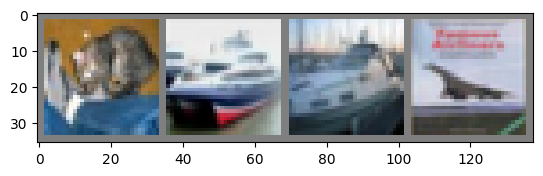

GroundTruth:    cat  ship  ship plane
Predicted:    cat plane   car plane
Accuracy of the network on the 10000 test images: 54.65%

Accuracy of plane : 66 %
Accuracy of   car : 66 %
Accuracy of  bird : 24 %
Accuracy of   cat : 26 %
Accuracy of  deer : 72 %
Accuracy of   dog : 40 %
Accuracy of  frog : 61 %
Accuracy of horse : 62 %
Accuracy of  ship : 50 %
Accuracy of truck : 74 %


In [27]:
initial_accuracy = test_model(net, testloader, classes)

The `LoRALinear` class is implemented below. This could be implemented in a ton of ways, but I chose create it in such a way that it could take the original linear layer as an argument and return a LoRA-adapted linear layer.

Note that the original weights and biases from the linear layer are copied into `self.pretrained` and are then frozen so that the parameters won't be modified.

In [28]:
# let's start building out a LoRALinear layer
class LoRALinear(nn.Module):
  """
  This is a low-rank adapted linear layer that can be used to replace a standard linear layer.
  
  
  Args:
    module: The linear layer module to adapt.
    rank: The rank of the approximation.
    alpha: The alpha parameter.
  """

  def __init__(
    self,
    module: nn.Module,
    # in_dim: int,
    # out_dim: int,
    rank: int = 4,
    alpha: float = 4.0
  ):
    # ensure the module is a linear layer
    assert isinstance(module, nn.Linear), "Module must be a linear layer."

    super().__init__() # call the __init__() method of the parent class
    self.rank = rank # rank of the approximation
    self.alpha = alpha # alpha parameter
    self.scaling = self.alpha / self.rank # scaling factor
    self.in_dim = module.in_features # number of input features
    self.out_dim = module.out_features # number of output features

    # make sure that rank is at least 1
    assert self.rank >= 1, "Rank must be at least 1."

    # recreate the linear layer and freeze it
    # note: we will copy over the pretrained weights after initializing
    self.pretrained = nn.Linear(self.in_dim, self.out_dim, bias=True)
    self.pretrained.weight = nn.Parameter(module.weight.detach().clone())
    self.pretrained.bias = nn.Parameter(module.bias.detach().clone())
    self.pretrained.weight.requires_grad = False # freeze the weights
    self.pretrained.bias.requires_grad = False # freeze the bias

    # create the A and initialize with Kaiming
    self.A = nn.Linear(self.in_dim, rank, bias=False)
    nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))

    # create B and initialize with zeros
    self.B = nn.Linear(rank, self.out_dim, bias=False)
    nn.init.zeros_(self.B.weight)

    # ensure that the weights in A and B are trainable
    self.A.weight.requires_grad = True
    self.B.weight.requires_grad = True

  def forward(self, x: torch.Tensor):
    """
    Perform the forward pass of the layer.
    
    Args:
      x: The input tensor.
    """
    pretrained_out = self.pretrained(x) # get the pretrained weights
    lora_out = self.A(x) # 
    lora_out = self.B(lora_out)
    lora_out = lora_out * self.scaling
    return pretrained_out + lora_out
  





Now we just need a few utility functions. Most importantly, I want to be able to take any given pytorch model that has `nn.Linear` layers and quickly adapt it so that it uses `LoRALinear` layers instead.

In [29]:
def freeze_parameters(model: nn.Module):
  """
  Freeze all parameters in the model.
  
  Args:
    model: The model to freeze the parameters of.
  """
  for param in model.parameters(): # iterate over the parameters of the model
    param.requires_grad = False # freeze the parameter

def unfreeze_parameters(model: nn.Module):
  """
  Unfreeze all parameters in the model.
  
  Args:
    model: The model to unfreeze the parameters of.
  """
  for param in model.parameters(): # iterate over the parameters of the model
    param.requires_grad = True # unfreeze the parameter

# create a function to replace all linear layers in the the net with LoRALinear layers
def update_model(model: nn.Module, rank: int = 4, alpha: float = 4.0, device: str = 'cpu'):
  """
  Replaces all linear layers in the model with LoRALinear layers.
  
  Args:
    model: The model to update.
    rank: The rank of the approximation.
    alpha: The alpha parameter.
  """
  # make sure there are no LoRALinear layers in the model; return if there are
  for name, module in model.named_modules():
    if isinstance(module, LoRALinear):
      print("Model already contains LoRALinear layers.")
      return
      
  freeze_parameters(model) # freeze all parameters in the model

  for name, module in model.named_children(): # iterate over the children of the model
    if isinstance(module, nn.Linear): # if the module is a linear layer
      setattr(model, name, LoRALinear(module, rank, alpha)) # replace it with a LoRALinear layer
      print(f"Replaced {name} with LoRALinear layer.")
    else: # otherwise
      update_model(module, rank, alpha) # recursively call the function on the module

  # move the model to the device
  model.to(device)

  # ensure low-rank matrices are trainable
  for name, module in model.named_modules():
    if isinstance(module, LoRALinear):
      module.A.weight.requires_grad = True
      module.B.weight.requires_grad = True

In [30]:
freeze_parameters(net)
print_params(net)
unfreeze_parameters(net)
print_params(net)

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- conv3.weight of size torch.Size([32, 16, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([32]) -> untrainable
- fc1.weight of size torch.Size([120, 400]) -> untrainable
- fc1.bias of size torch.Size([120]) -> untrainable
- fc2.weight of size torch.Size([84, 120]) -> untrainable
- fc2.bias of size torch.Size([84]) -> untrainable
- fc3.weight of size torch.Size([10, 84]) -> untrainable
- fc3.bias of size torch.Size([10]) -> untrainable

Trainable parameters: 0
Untrainable parameters: 74838
Total parameters: 74838
Percent trainable: 0.0%
Size of trainable parameters: 0.00 mb
Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> trainable
- conv1.bias of size torch.Size([6]) -> trainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> tr

After updating the model, only the `LoRALinear` parameters in the `A` and `B` matrices should be trainable. All other layers are frozen.

Note how this drastically reduces the memory required to store trainable parameters. This is one great advantage of LoRA -- someone can finetune a model and send you a small file of parameter deltas (instead of ALL of the weights) which you can use to immediately apply that same finetune to the same pretrained model.

In [31]:
update_model(net, device=device) # update the model
print_params(net) # print the number of parameters

Replaced fc1 with LoRALinear layer.
Replaced fc2 with LoRALinear layer.
Replaced fc3 with LoRALinear layer.
Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- conv3.weight of size torch.Size([32, 16, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([32]) -> untrainable
- fc1.pretrained.weight of size torch.Size([120, 400]) -> untrainable
- fc1.pretrained.bias of size torch.Size([120]) -> untrainable
- fc1.A.weight of size torch.Size([4, 400]) -> trainable
- fc1.B.weight of size torch.Size([120, 4]) -> trainable
- fc2.pretrained.weight of size torch.Size([84, 120]) -> untrainable
- fc2.pretrained.bias of size torch.Size([84]) -> untrainable
- fc2.A.weight of size torch.Size([4, 120]) -> trainable
- fc2.B.weight of size torch.Size([84, 4]) -> trainable
- fc3.pretrained.weight of size torch.Size(

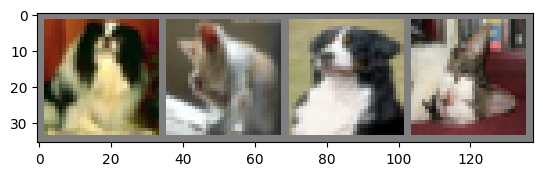

In [32]:
# it looks like the 'cat', 'bird', and 'dog' classes had a low accuracy; let's fine tune the
# lora-adapted model on those classes

# create a new trainset that only contains the cat, bird, and dog classes
new_trainset = [data for data in trainset if data[1] == classes.index('cat') or data[1] == classes.index('bird') or data[1] == classes.index('dog')]

# create a trainloader for only the cat, bird, and dog classes
new_trainloader = torch.utils.data.DataLoader(new_trainset, batch_size=4, shuffle=True, num_workers=2)

# let's print a few of the cat images# Display some of the cat images
new_dataiter = iter(new_trainloader) # create an iterator
new_images, new_labels = next(new_dataiter) # get the next batch of images and labels

# print images
showimg(torchvision.utils.make_grid(new_images))


In [33]:
# let's continue training the lora-adapted model on just the cat class
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9) # update the optimizer for the new parameters
train(net, criterion, optimizer, new_trainloader, num_epochs=2, device=device, announce=100)


[1,  2000] loss: 30.019
Finished epoch 1
[2,  2000] loss: 16.266
Finished epoch 2
Finished training


After finetuning the LoRA model, we would expect that the `B` matrices aren't all zeros anymore. We would also expect that the classification accuracy on dogs, cats, and birds has increased.

In [34]:
# double check the params
print_params(net)

# some of the A and B matrices should have changed
# check to see if B weights are non-zero
for name, param in net.named_parameters():
  if 'B.weight' in name:
    print(f"{name} has all zero weights: {torch.all(param == 0)}")

Layers:
- conv1.weight of size torch.Size([6, 3, 5, 5]) -> untrainable
- conv1.bias of size torch.Size([6]) -> untrainable
- conv2.weight of size torch.Size([16, 6, 5, 5]) -> untrainable
- conv2.bias of size torch.Size([16]) -> untrainable
- conv3.weight of size torch.Size([32, 16, 5, 5]) -> untrainable
- conv3.bias of size torch.Size([32]) -> untrainable
- fc1.pretrained.weight of size torch.Size([120, 400]) -> untrainable
- fc1.pretrained.bias of size torch.Size([120]) -> untrainable
- fc1.A.weight of size torch.Size([4, 400]) -> trainable
- fc1.B.weight of size torch.Size([120, 4]) -> trainable
- fc2.pretrained.weight of size torch.Size([84, 120]) -> untrainable
- fc2.pretrained.bias of size torch.Size([84]) -> untrainable
- fc2.A.weight of size torch.Size([4, 120]) -> trainable
- fc2.B.weight of size torch.Size([84, 4]) -> trainable
- fc3.pretrained.weight of size torch.Size([10, 84]) -> untrainable
- fc3.pretrained.bias of size torch.Size([10]) -> untrainable
- fc3.A.weight of siz

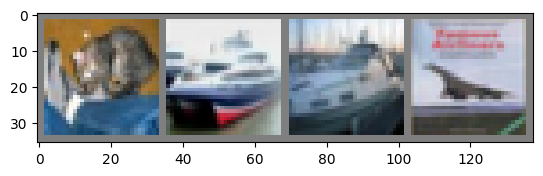

GroundTruth:    cat  ship  ship plane
Predicted:    cat plane  bird  bird
Accuracy of the network on the 10000 test images: 21.21%

Accuracy of plane :  7 %
Accuracy of   car :  7 %
Accuracy of  bird : 72 %
Accuracy of   cat : 45 %
Accuracy of  deer :  0 %
Accuracy of   dog : 64 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship : 11 %
Accuracy of truck :  4 %


In [35]:
# let's check the accuracy on all classes again; we should see an improvement in the cat class
new_accuracy = test_model(net, testloader, classes)

In [36]:
# compare initial_accuracy and new_accuracy by printing the change in
# accuracy for each class 
for key in initial_accuracy.keys():
  change = new_accuracy[key] - initial_accuracy[key]
  if change > 0:
    print(f"{key}: +{change:.1f}%")
  else:
    print(f"{key}: {change:.1f}%")

plane: -59.4%
car: -59.6%
bird: +48.1%
cat: +19.3%
deer: -72.9%
dog: +23.2%
frog: -61.5%
horse: -62.3%
ship: -39.0%
truck: -70.3%
